In [2]:
from qiskit.circuit.library.standard_gates import RXGate, RZGate, RYGate, CXGate, CZGate, SGate, HGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

import numpy as np

In [3]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

In [4]:
def get_linear_entangelment_ansatz(num_of_qubits, thetas, input_state, circuit_depth=3):
    quantum_register = QuantumRegister(num_of_qubits, name="qubit")
    quantum_circuit = QuantumCircuit(quantum_register)
    quantum_circuit.initialize(input_state)

    for iteration in range(circuit_depth):
        for qubit_index in range(num_of_qubits):
            RY_theta_index = iteration*2*num_of_qubits + qubit_index
            RZ_theta_index = RY_theta_index + num_of_qubits
            
            quantum_circuit.append(RYGate(thetas[RY_theta_index]), [quantum_register[qubit_index]])
            quantum_circuit.append(RZGate(thetas[RZ_theta_index]), [quantum_register[qubit_index]])
            
        for qubit_index in range(num_of_qubits - 1):
            quantum_circuit.append(CXGate(), [quantum_register[qubit_index], quantum_register[qubit_index + 1]])

    for qubit_index in range(num_of_qubits):
            RY_theta_index = 2*num_of_qubits*circuit_depth + qubit_index
            RZ_theta_index = RY_theta_index + num_of_qubits
            quantum_circuit.append(RYGate(thetas[RY_theta_index]), [quantum_register[qubit_index]])
            quantum_circuit.append(RZGate(thetas[RZ_theta_index]), [quantum_register[qubit_index]])

    return quantum_circuit

In [5]:
def get_full_entangelment_ansatz(num_of_qubits, thetas, input_state, circuit_depth=3):
    quantum_register = QuantumRegister(num_of_qubits, name="qubit")
    quantum_circuit = QuantumCircuit(quantum_register)
    quantum_circuit.initialize(input_state)

    for iteration in range(circuit_depth):
        for qubit_index in range(num_of_qubits):
            RY_theta_index = iteration*2*num_of_qubits + qubit_index
            RZ_theta_index = RY_theta_index + num_of_qubits
            
            quantum_circuit.append(RYGate(thetas[RY_theta_index]), [quantum_register[qubit_index]])
            quantum_circuit.append(RZGate(thetas[RZ_theta_index]), [quantum_register[qubit_index]])
        for qubit_index in range(num_of_qubits - 1):
            for target_qubit_index in range(qubit_index + 1, num_of_qubits):
                quantum_circuit.append(CXGate(), [quantum_register[qubit_index], quantum_register[target_qubit_index]])

    for qubit_index in range(num_of_qubits):
            RY_theta_index = 2*num_of_qubits*circuit_depth + qubit_index
            RZ_theta_index = RY_theta_index + num_of_qubits
            
            quantum_circuit.append(RYGate(thetas[RY_theta_index]), [quantum_register[qubit_index]])
            quantum_circuit.append(RZGate(thetas[RZ_theta_index]), [quantum_register[qubit_index]])

    return quantum_circuit

In [6]:
QUBITS_NUM = 2
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

#### convert hamiltonian to pauli strings

In [7]:
from typing import Dict, Tuple, List

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

In [9]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [10]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [11]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

#### probabilities distribution

In [12]:
from qiskit import assemble, transpile

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

#### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in zip(pauli_coeffs, pauli_strings):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## MUBs d=4

In [16]:
from typing import List

class MUB:
    def __init__(self, name: str, color: str, basis_vectors, dim: int):
        self.name = name
        self.color = color
        self.basis_vectors = basis_vectors
        self.results = []
        
    def add_result(self, result:int):
        self.results.append(result)
        
    def restart_results(self):
        self.results = []

In [17]:
M0_vectors = np.identity(N)

M1_vectors = [np.vectorize(complex)([0.5,0.5,0.5,0.5]),
      np.vectorize(complex)([0.5,0.5,-0.5,-0.5]),
      np.vectorize(complex)([0.5,-0.5,-0.5,0.5]),
      np.vectorize(complex)([0.5,-0.5,0.5,-0.5])]

M2_vectors = [np.vectorize(complex)([0.5,0.5,0,0],[0,0,-0.5,-0.5]),
      np.vectorize(complex)([0.5,-0.5,0,0],[0,0,0.5,0.5]),
      np.vectorize(complex)([0.5,0.5,0,0],[0,0,0.5,-0.5]),
      np.vectorize(complex)([0.5,0.5,0,0],[0,0,-0.5,0.5])]

M3_vectors = [np.vectorize(complex)([0.5,0,0,-0.5],[0,-0.5,-0.5,-0]),
      np.vectorize(complex)([0.5,0,0,0.5],[0,-0.5,0.5,0]),
      np.vectorize(complex)([0.5,0,0,-0.5],[0,0.5,0.5,0]),
      np.vectorize(complex)([0.5,0,0,0.5],[0,0.5,-0.5,0])]

M4_vectors = [np.vectorize(complex)([0.5,0,-0.5,0],[0,-0.5,0,-0.5]),
      np.vectorize(complex)([0.5,0,0.5,0],[0,-0.5,0,0.5]),
      np.vectorize(complex)([0.5,0,-0.5,0],[0,0.5,0,0.5]),
      np.vectorize(complex)([0.5,0,0.5,0],[0,0.5,0,-0.5])]

In [18]:
M0 = MUB(name='M0', color='b', basis_vectors=M0_vectors, dim=4)
M1 = MUB(name='M1', color='c', basis_vectors=M1_vectors, dim=4)
M2 = MUB(name='M2', color='y', basis_vectors=M2_vectors, dim=4)
M3 = MUB(name='M3', color='m', basis_vectors=M3_vectors, dim=4)
M4 = MUB(name='M4', color='r', basis_vectors=M4_vectors, dim=4)

mubs_d_5 = [M0, M1, M2, M3, M4]

### H2 Molecule 2 qubits

In [19]:
from matplotlib import pyplot as plt

In [20]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

In [21]:
thetas = np.random.uniform(low=0, high=360, size=PARAMS_NUM)

### full entangelment

In [30]:
for basis in mubs_d_5:
    basis.restart_results()
    for vector in basis.basis_vectors:
        pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(H2_molecule_Hamiltonian_2_qubits)
        ansatz_state = get_full_entangelment_ansatz(QUBITS_NUM, thetas, vector)

        L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        basis.add_result(L)

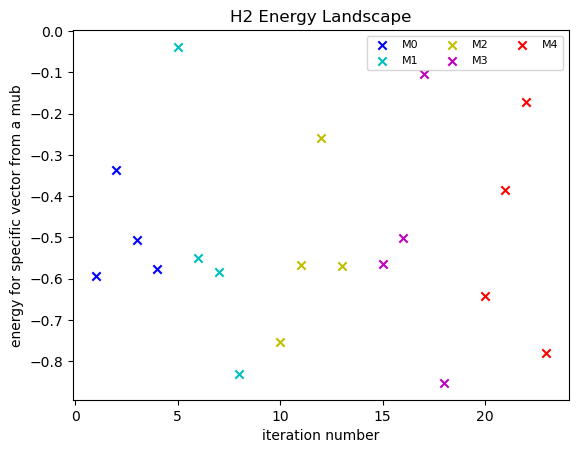

In [31]:
M0_points = plt.scatter(x=range(1,5),y=M0.results, marker='x', color=M0.color)
M1_points = plt.scatter(x=range(5,9),y=M1.results, marker='x', color=M1.color)
M2_points = plt.scatter(x=range(10,14),y=M2.results, marker='x', color=M2.color)
M3_points = plt.scatter(x=range(15,19),y=M3.results, marker='x', color=M3.color)
M4_points = plt.scatter(x=range(20,24),y=M4.results, marker='x', color=M4.color)

plt.legend((M0_points, M1_points, M2_points, M3_points, M4_points),
           (M0.name, M1.name, M2.name, M3.name, M4.name),
           scatterpoints=1,
           loc='best',
           ncol=3,
           fontsize=8)

plt.xlabel('iteration number')
plt.ylabel('energy for specific vector from a mub')
plt.title('H2 Energy Landscape')

plt.show()

In [ ]:
v0 = M0_vectors[2]

In [25]:
v1 = np.vectorize(complex)([0,0,0,0],[0,0,1,0])

In [26]:
pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(H2_molecule_Hamiltonian_2_qubits)
ansatz_state = get_full_entangelment_ansatz(QUBITS_NUM, thetas, v1)

L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
print(L)

-0.48834251803032236


## Transverse Ising Model 2 qubits

In [27]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

In [28]:
for basis in mubs_d_5:
    basis.restart_results()
    for vector in basis.basis_vectors:
        pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(transverse_ising_2_qubits)
        ansatz_state = get_full_entangelment_ansatz(QUBITS_NUM, thetas, vector)

        L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
        basis.add_result(L)

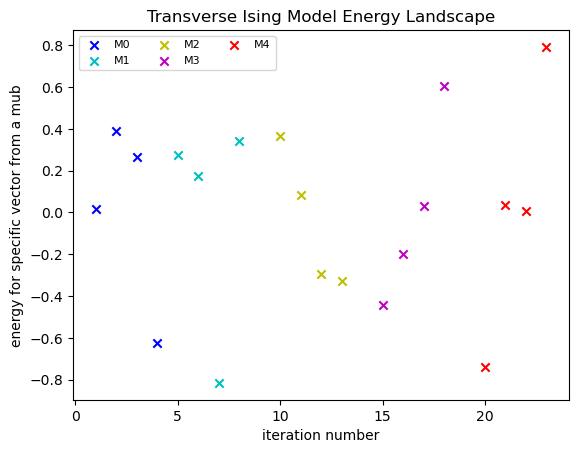

In [29]:
M0_points = plt.scatter(x=range(1,5),y=M0.results, marker='x', color=M0.color)
M1_points = plt.scatter(x=range(5,9),y=M1.results, marker='x', color=M1.color)
M2_points = plt.scatter(x=range(10,14),y=M2.results, marker='x', color=M2.color)
M3_points = plt.scatter(x=range(15,19),y=M3.results, marker='x', color=M3.color)
M4_points = plt.scatter(x=range(20,24),y=M4.results, marker='x', color=M4.color)

plt.legend((M0_points, M1_points, M2_points, M3_points, M4_points),
           (M0.name, M1.name, M2.name, M3.name, M4.name),
           scatterpoints=1,
           loc='best',
           ncol=3,
           fontsize=8)

plt.xlabel('iteration number')
plt.ylabel('energy for specific vector from a mub')
plt.title('Transverse Ising Model Energy Landscape')

plt.show()